In [ ]:
%%writefile /kaggle/working/r4.2/optimized_feature_extraction.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Optimized Feature Extraction v3.5 (Fix: Ambiguous Truth Value in Email Logic)
"""
import os, sys, time
import pandas as pd
import numpy as np
from datetime import datetime
import shutil
from joblib import Parallel, delayed
import glob

# --- CẤU HÌNH ---
DNAME = 'r4.2'
NUM_WEEK = 73 
CHUNK_SIZE = 5000000 

# MASTER SCHEMA (Để chuẩn hóa cột CSV)
ALL_COLS = [
    'id', 'date', 'user', 'pc', 'activity', 'type', 
    'to', 'cc', 'bcc', 'from', 'size', '#att', 'content', 
    'url/fname'
]

# ==========================================
# 1. HELPER & VECTORIZED LOGIC
# ==========================================
def extract_row_features_vectorized(df, users_df):
    # 1. TIME
    df['hour'] = df['dt'].dt.hour
    df['weekday'] = df['dt'].dt.weekday
    is_weekend = df['weekday'] >= 5
    is_after = (df['hour'] < 8) | (df['hour'] > 17)
    conditions = [ (is_weekend & is_after), is_weekend, is_after ]
    choices = [4, 3, 2]
    df['time'] = np.select(conditions, choices, default=1)
    
    # 2. PC CHECK
    df = df.merge(users_df[['pc']], left_on='user', right_index=True, how='left')
    df['pc_type'] = np.where(df['pc_x'] == df['pc_y'], 0, 2)
    df.drop(columns=['pc_y'], inplace=True)
    df.rename(columns={'pc_x': 'pc'}, inplace=True)

    # 3. FEATURES
    feature_cols = [f'f{i}' for i in range(20)]
    for c in feature_cols: df[c] = 0
    
    # FILE
    is_file = df['type'] == 'file'
    if is_file.any():
        fname_vals = df.loc[is_file, 'url/fname'].astype(str).fillna('').values
        content_vals = df.loc[is_file, 'content'].astype(str).fillna('').values
        
        ftype = np.ones(len(fname_vals))
        fname_s = pd.Series(fname_vals)
        ftype[fname_s.str.contains(r'\.zip|\.rar|\.7z', regex=True)] = 2
        ftype[fname_s.str.contains(r'\.jpg|\.png|\.bmp', regex=True)] = 3
        ftype[fname_s.str.contains(r'\.doc|\.pdf', regex=True)] = 4
        ftype[fname_s.str.contains(r'\.txt|\.cfg', regex=True)] = 5
        ftype[fname_s.str.contains(r'\.exe|\.sh', regex=True)] = 6
        
        df.loc[is_file, 'f1'] = ftype
        df.loc[is_file, 'f2'] = [len(s) for s in content_vals]
        df.loc[is_file, 'f3'] = [s.count(' ')+1 for s in content_vals]
        df.loc[is_file, 'f4'] = np.where(pd.Series(fname_vals).str.startswith('C'), 1, 
                                np.where(pd.Series(fname_vals).str.startswith('R'), 2, 0))
        df.loc[is_file, 'f5'] = [s.count('\\') for s in fname_vals]

    # HTTP
    is_http = df['type'] == 'http'
    if is_http.any():
        url_vals = df.loc[is_http, 'url/fname'].astype(str).fillna('').values
        content_vals = df.loc[is_http, 'content'].astype(str).fillna('').values
        
        htype = np.ones(len(url_vals))
        url_s = pd.Series(url_vals)
        htype[url_s.str.contains('facebook|twitter|instagram', case=False)] = 2
        htype[url_s.str.contains('dropbox|drive.google', case=False)] = 3
        htype[url_s.str.contains('job|indeed|recruit', case=False)] = 4
        htype[url_s.str.contains('wikileaks|hack', case=False)] = 5
        
        df.loc[is_http, 'f6'] = htype
        df.loc[is_http, 'f7'] = [len(s) for s in url_vals]
        df.loc[is_http, 'f8'] = [s.count('/')-2 for s in url_vals]
        df.loc[is_http, 'f9'] = [len(s) for s in content_vals]
        df.loc[is_http, 'f10'] = [s.count(' ')+1 for s in content_vals]

    # EMAIL
    is_email = df['type'] == 'email'
    if is_email.any():
        to_vals = df.loc[is_email, 'to'].astype(str).fillna('').values
        bcc_vals = df.loc[is_email, 'bcc'].astype(str).fillna('').values
        content_vals = df.loc[is_email, 'content'].astype(str).fillna('').values
        
        n_to = [s.count(';')+1 if s else 0 for s in to_vals]
        n_bcc = [s.count(';')+1 if s else 0 for s in bcc_vals]
        
        df.loc[is_email, 'f11'] = np.array(n_to) + np.array(n_bcc)
        df.loc[is_email, 'f12'] = df.loc[is_email, '#att'].fillna(0)
        
        to_s = pd.Series(to_vals)
        bcc_s = pd.Series(bcc_vals)
        
        # --- FIX LỖI TẠI ĐÂY: Thay 'or' bằng '|' và đóng ngoặc ---
        # Logic: (To nội bộ) VÀ (Bcc rỗng HOẶC Bcc nội bộ) -> Internal (0)
        # Ngược lại -> External (1)
        # Lưu ý: 'dtaa.com' là domain công ty trong dataset CERT
        
        is_internal_to = to_s.str.contains('dtaa.com', regex=False)
        is_internal_bcc = (bcc_s == '') | bcc_s.str.contains('dtaa.com', regex=False)
        
        # Nếu cả To và Bcc đều an toàn -> 0, ngược lại -> 1
        xemail = np.where(is_internal_to & is_internal_bcc, 0, 1)
        
        df.loc[is_email, 'f13'] = xemail
        df.loc[is_email, 'f17'] = df.loc[is_email, 'size'].fillna(0)
        df.loc[is_email, 'f18'] = [len(s) for s in content_vals]
        df.loc[is_email, 'f19'] = [s.count(' ')+1 for s in content_vals]

    # Act Code
    conditions = [
        df['type'] == 'logon', df['type'] == 'device', 
        df['type'] == 'http', df['type'] == 'email', df['type'] == 'file'
    ]
    choices = [1, 3, 5, 6, 7]
    df['act_code'] = np.select(conditions, choices, default=0)
    
    df.loc[(df['type']=='logon') & (df['activity']!='Logon'), 'act_code'] = 2
    df.loc[(df['type']=='device') & (df['activity']!='Connect'), 'act_code'] = 4
    
    return df

# ==========================================
# 2. STEP 1: FAST SPLIT (Standardized)
# ==========================================
def fast_split_by_week():
    # Kiểm tra số lượng file CSV
    if os.path.exists("DataByWeek") and len(glob.glob("DataByWeek/*.csv")) > 60:
        print("⚡ Step 1 (Split) đã có dữ liệu hợp lệ. Bỏ qua.")
        return

    print("🚀 Step 1: Tách dữ liệu (Vectorized + Standardized)...")
    if os.path.exists("DataByWeek"): shutil.rmtree("DataByWeek")
    os.makedirs("DataByWeek")

    START_DATE = datetime.strptime('2010-01-02', '%Y-%m-%d')
    files = ['device.csv', 'email.csv', 'file.csv', 'http.csv', 'logon.csv']
    
    for fname in files:
        if not os.path.exists(fname): continue
        print(f"  -> Xử lý {fname}...")
        act_type = fname.split('.')[0]
        
        for chunk in pd.read_csv(fname, chunksize=CHUNK_SIZE, on_bad_lines='skip', engine='python'):
            chunk['dt'] = pd.to_datetime(chunk['date'], format="%m/%d/%Y %H:%M:%S")
            chunk['week_num'] = (chunk['dt'] - START_DATE).dt.days // 7
            chunk['type'] = act_type
            
            # CHUẨN HÓA CỘT
            chunk = chunk.reindex(columns=ALL_COLS + ['week_num', 'dt'])
            
            for w, group in chunk.groupby('week_num'):
                if w < 0 or w >= NUM_WEEK: continue
                save_path = f"DataByWeek/{int(w)}.csv"
                header = not os.path.exists(save_path)
                group.drop(columns=['week_num', 'dt']).to_csv(save_path, mode='a', index=False, header=header)

# ==========================================
# 3. STEP 2: USER & LABEL
# ==========================================
def get_mal_userdata():
    possible_paths = ["/kaggle/input/cert42-answer/answers"]
    found = False
    for p in possible_paths:
        if os.path.exists(os.path.join(p, "insiders.csv")):
            if not os.path.exists("answers"):
                try: os.symlink(p, "answers")
                except: shutil.copytree(p, "answers")
            found = True
            break
            
    print("  -> Đang đọc LDAP...")
    allfiles = glob.glob('LDAP/*.csv')
    alluser = {}
    for file in sorted(allfiles):
        month = os.path.basename(file).split('.')[0]
        df_ldap = pd.read_csv(file)
        for _, row in df_ldap.iterrows():
            if row['user_id'] not in alluser:
                alluser[row['user_id']] = row.drop('user_id').tolist() + [month, np.nan]

    if os.path.isfile("psychometric.csv"):
        p_score = pd.read_csv("psychometric.csv")
        for _, row in p_score.iterrows():
            if row['user_id'] in alluser: 
                alluser[row['user_id']] += row.iloc[2:].tolist()

    cols = ['uname', 'email', 'role', 'b_unit', 'f_unit', 'dept', 'team', 'sup', 'wstart', 'wend', 'O', 'C', 'E', 'A', 'N']
    df = pd.DataFrame.from_dict(alluser, orient='index', columns=cols)
    
    if os.path.exists("DataByWeek/1.csv"):
        try:
            w1 = pd.read_csv("DataByWeek/1.csv", usecols=['user','pc'])
            user_pcs = w1.groupby('user')['pc'].apply(lambda x: list(set(x))).to_dict()
        except: user_pcs = {}
    else: user_pcs = {}
    df['pc'] = df.index.map(lambda x: user_pcs.get(x, [None])[0])

    print("  -> Nạp danh sách hành vi Insider...")
    malicious_ids_set = set()
    if os.path.exists("answers/insiders.csv"):
        insiders = pd.read_csv("answers/insiders.csv")
        insiders = insiders[insiders['dataset'].astype(str) == '4.2']
        for _, row in insiders.iterrows():
            path1 = f"answers/{row['details']}"
            path2 = f"answers/r4.2-{row['scenario']}/{os.path.basename(row['details'])}"
            final = path1 if os.path.exists(path1) else (path2 if os.path.exists(path2) else None)
            if final:
                try:
                    mal_log = pd.read_csv(final, header=None, engine='python', on_bad_lines='skip')
                    if mal_log.shape[1] > 1: malicious_ids_set.update(mal_log[1].values)
                except: pass
    
    print(f"     => {len(malicious_ids_set)} hành vi độc hại.")
    return df, malicious_ids_set

# ==========================================
# 4. STEP 3: PIPELINE (PARQUET)
# ==========================================
def process_week_vectorized(week, users_df, mal_ids_set):
    csv_path = f"DataByWeek/{week}.csv"
    if not os.path.exists(csv_path): return
    try: df = pd.read_csv(csv_path, low_memory=False)
    except: return
    if df.empty: return
    
    df['dt'] = pd.to_datetime(df['date'], format="%m/%d/%Y %H:%M:%S")
    df.sort_values('dt', inplace=True)
    
    # Extract Features
    df = extract_row_features_vectorized(df, users_df)
    
    # Label
    df['mal_act'] = df['id'].isin(mal_ids_set).astype(int)
    
    week_res = []
    
    for u, u_group in df.groupby('user'):
        if u not in users_df.index: continue
        
        u_static = users_df.loc[u, ['O','C','E','A','N','role','dept']].tolist()
        dyn_feats = [1 if (u_group['time'] >= 3).any() else 0] 
        
        act_col_map = {
            3: ['f0'], 7: ['f1','f2','f3','f4','f5'],
            6: ['f11','f12','f17','f19'], 5: ['f7','f8','f10']
        }
        
        for act_code in [1, 3, 5, 6, 7]:
            cols_to_stat = act_col_map.get(act_code, [])
            act_rows = u_group[u_group['act_code'] == act_code]
            
            for tm in ['all', 1, 2, 3]:
                if tm == 'all': curr = act_rows
                elif tm == 3: curr = act_rows[act_rows['time'] >= 3]
                else: curr = act_rows[act_rows['time'] == tm]
                
                stats = [len(curr)]
                for c in cols_to_stat:
                    if len(curr) > 0:
                        vals = pd.to_numeric(curr[c], errors='coerce').values
                        stats.extend([np.nanmean(vals), np.nanstd(vals), np.nanmin(vals), np.nanmax(vals)])
                    else: stats.extend([0,0,0,0])
                dyn_feats.extend(stats)

        is_insider = 1 if u_group['mal_act'].sum() > 0 else 0
        week_res.append([week, u] + u_static + dyn_feats + [is_insider])

    if week_res:
        out_dir = 'ExtractedData/week_parquet'
        os.makedirs(out_dir, exist_ok=True)
        res_df = pd.DataFrame(week_res)
        res_df.columns = res_df.columns.astype(str)
        res_df.to_parquet(f"{out_dir}/part_{week}.parquet", index=False)

if __name__ == "__main__":
    st = time.time()
    
    fast_split_by_week()
    print(f"✅ Step 1 Done. Time: {(time.time()-st)/60:.2f} m")
    
    users, mal_ids = get_mal_userdata()
    print(f"✅ Step 2 Done. Time: {(time.time()-st)/60:.2f} m")
    
    print("🚀 Step 3: Tính toán & Xuất Parquet...")
    Parallel(n_jobs=4)(delayed(process_week_vectorized)(i, users, mal_ids) for i in range(NUM_WEEK))
    print(f"🎉 ALL DONE. Total Time: {(time.time()-st)/60:.2f} m")

    # Kiểm tra lần cuối
    pq_files = glob.glob("ExtractedData/week_parquet/*.parquet")
    if len(pq_files) > 0:
        print(f"-> THÀNH CÔNG: Tìm thấy {len(pq_files)} file parquet.")
    else:
        print("-> CẢNH BÁO: Vẫn không thấy file parquet. Kiểm tra lại Logs.")

In [2]:
# Xóa thư mục cũ chứa file lỗi
!rm -rf /kaggle/working/act_type_map.json
!rm -rf /kaggle/working/dept_map.json
!rm -rf /kaggle/working/role_map.json
!rm -rf /kaggle/working/role_map.json
!rm -rf /kaggle/working/team_map.json
!rm -rf /kaggle/working/tmp_device
!rm -rf /kaggle/working/tmp_email
!rm -rf /kaggle/working/tmp_file
!rm -rf /kaggle/working/tmp_http
!rm -rf /kaggle/working/tmp_logon

print("Đã dọn dẹp file lỗi. Bây giờ bạn hãy chạy lại script chính nhé!")

Đã dọn dẹp file lỗi. Bây giờ bạn hãy chạy lại script chính nhé!


In [3]:
# ================= CERT r4.2 ACTION-LEVEL MULTICLASS UEBA PIPELINE =================
# One-cell | Kaggle-ready | Deep Learning + Explainable

import os, shutil, time, json
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# ================= CONFIG =================
SOURCE_DIR = '/kaggle/input/cert-r4-2/archive'
ANSWERS_DIR = '/kaggle/input/cert42-answer/answers'
OUTPUT_DIR = '/kaggle/working'
CHUNK_SIZE = 2_000_000
NUM_CORES = 4

ACT_MAP = {'logon':1, 'device':2, 'file':3, 'email':4, 'http':5}
#ORG_DOMAIN = 'dtaa.com'
#EXEC_EXT = ('.exe','.zip','.tar')
#SENSITIVE_PREFIX = 'R'
#RISKY_HTTP = ['job','hack','leak','upload','drive','dropbox','keylog']

# ================= 1. USER CONTEXT =================
def load_user_context():
    ldap_dir = os.path.join(SOURCE_DIR,'LDAP')
    if not os.path.exists(ldap_dir): ldap_dir = SOURCE_DIR

    users={}
    for f in os.listdir(ldap_dir):
        if f.endswith('.csv'):
            df=pd.read_csv(os.path.join(ldap_dir,f))
            for _,r in df.iterrows():
                users[r['user_id']] = r.to_dict()

    df_users=pd.DataFrame.from_dict(users,orient='index')

    psy=os.path.join(SOURCE_DIR,'psychometric.csv')
    if os.path.exists(psy):
        df_users=df_users.merge(pd.read_csv(psy),on='user_id',how='left')
    else:
        for c in ['O','C','E','A','N']: df_users[c]=0.5

    def enc(col): return {v:i+1 for i,v in enumerate(sorted(col.fillna('UNK').unique()))}

    role_map,dept_map,team_map=enc(df_users['role']),enc(df_users['department']),enc(df_users['team'])

    for m,n in [(role_map,'role'),(dept_map,'dept'),(team_map,'team')]:
        with open(f'{OUTPUT_DIR}/{n}_map.json','w') as f:
            json.dump({str(v):k for k,v in m.items()},f,indent=2)

    with open(f'{OUTPUT_DIR}/act_type_map.json','w') as f:
        json.dump({str(v):k for k,v in ACT_MAP.items()},f,indent=2)

    ctx={}
    for _,r in df_users.iterrows():
        ctx[r['user_id']]=[
            role_map.get(r['role'],0),
            dept_map.get(r['department'],0),
            team_map.get(r['team'],0),
            float(r['O']),float(r['C']),float(r['E']),float(r['A']),float(r['N'])
        ]
    return ctx

# ================= 2. LOAD MALICIOUS IDS =================
def load_malicious_ids():
    df=pd.read_csv(os.path.join(ANSWERS_DIR,'insiders.csv'))
    df=df[df['dataset'].astype(str)=='4.2']
    ids=set()
    for _,r in df.iterrows():
        f=os.path.join(ANSWERS_DIR,f"r4.2-{r['scenario']}",r['details'])
        if os.path.exists(f):
            with open(f) as fh:
                for l in fh:
                    ids.add(l.strip().split(',')[1].replace('{','').replace('}',''))
    return mal_ids

# ================= 3. FEATURE ENGINEERING =================
# def add_time_features(df):
#     df['dt']=pd.to_datetime(df['date'],errors='coerce')
#     df=df.dropna(subset=['dt'])
#     df['ts']=(df['dt'].astype('int64')//10**9).astype(np.int64)
#     df['hour']=df['dt'].dt.hour.astype(np.int8)
#     df['dow']=df['dt'].dt.dayofweek.astype(np.int8)
#     df['is_weekend']=(df['dow']>=5).astype(np.int8)
#     df['is_after_hours']=((df['hour']<8)|(df['hour']>18)).astype(np.int8)
#     df['is_night']=((df['hour']<7)|(df['hour']>22)).astype(np.int8)
#     return df

# def add_user_context(df,ctx):
#     cols=['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
#     return pd.concat([df,pd.DataFrame(df['user'].map(lambda u:ctx.get(u,[0]*8)).tolist(),columns=cols)],axis=1)

# ================= 4. CHUNK PROCESS =================
# ================= 4. CHUNK PROCESS (UPDATED) =================
def process_chunk(chunk, act, ctx, mal_ids):
    # ================= 1. BASE CLEANING =================
    chunk['id'] = chunk['id'].astype(str).str.replace('{','').str.replace('}','')
    chunk['dt'] = pd.to_datetime(chunk['date'], errors='coerce')
    chunk = chunk.dropna(subset=['dt'])

    # ================= 2. TIME FEATURES =================
    chunk['ts'] = (chunk['dt'].astype('int64') // 10**9).astype(np.int64)
    chunk['hour'] = chunk['dt'].dt.hour.astype(np.int8)
    chunk['dow'] = chunk['dt'].dt.dayofweek.astype(np.int8)
    chunk['is_weekend'] = (chunk['dow'] >= 5).astype(np.int8)
    # UEBA Standard: Night (22h-7h), After Hours (18h-8h)
    chunk['is_after_hours'] = ((chunk['hour'] < 8) | (chunk['hour'] > 18)).astype(np.int8)
    chunk['is_night']       = ((chunk['hour'] < 7) | (chunk['hour'] > 22)).astype(np.int8)
    
    # ================= 3. USER CONTEXT =================
    ctx_cols = ['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
    u_vals = [ctx.get(u, [0]*8) for u in chunk['user']]
    chunk_ctx = pd.DataFrame(u_vals, columns=ctx_cols, index=chunk.index)
    chunk = pd.concat([chunk, chunk_ctx], axis=1)

    # ================= 4. MULTICLASS LABEL =================
    # 0: benign | 1: logon | 2: device | 3: file | 4: email | 5: http
    act_type_code = ACT_MAP[act]
    chunk['label'] = np.where(chunk['id'].isin(mal_ids), act_type_code, 0).astype(np.int8)
    chunk['activity_type'] = act_type_code # Feature cho model biết loại log

    # ================= 5. FEATURE ENGINEERING (LOGIC MỚI) =================
    # Khởi tạo tất cả cột đặc trưng bằng 0
    # Đặt tên cột rõ nghĩa thay vì f1, f2...
    features = [
        # File features
        'file_category', 'file_content_len', 'file_content_words', 
        'file_drive_type', 'file_depth',
        # HTTP features
        'http_category', 'http_url_len', 'http_url_depth', 
        'http_content_len', 'http_content_words',
        # Email features
        'email_recipients_count', 'email_attachment_count', 'email_is_external',
        'email_size', 'email_content_len', 'email_content_words',
        # Session features
        'is_session_start'
    ]
    
    for f in features:
        chunk[f] = 0.0 # Dùng float để tránh lỗi tính toán, sau này model tự xử lý

    # ---------------------------------------------------------
    # A. XỬ LÝ FILE (Logic mapping từ f1 -> f5)
    # ---------------------------------------------------------
    if act == 'file':
        fname = chunk['filename'].fillna('').astype(str)
        content = chunk['content'].fillna('').astype(str)
        fname_lower = fname.str.lower()

        # F1: File Category (1:Other, 2:Archive, 3:Image, 4:Doc, 5:Text, 6:Exe)
        # Mặc định là 1
        chunk['file_category'] = 1 
        chunk.loc[fname_lower.str.contains(r'\.zip|\.rar|\.7z', regex=True), 'file_category'] = 2
        chunk.loc[fname_lower.str.contains(r'\.jpg|\.png|\.bmp', regex=True), 'file_category'] = 3
        chunk.loc[fname_lower.str.contains(r'\.doc|\.pdf|\.xls|\.ppt', regex=True), 'file_category'] = 4
        chunk.loc[fname_lower.str.contains(r'\.txt|\.cfg|\.csv', regex=True), 'file_category'] = 5
        chunk.loc[fname_lower.str.contains(r'\.exe|\.sh|\.bat', regex=True), 'file_category'] = 6

        # F2, F3: Content Length & Word Count
        chunk['file_content_len'] = content.str.len()
        chunk['file_content_words'] = content.str.count(' ') + 1

        # F4: Drive Type (1: C local, 2: R removeable/network, 0: Other)
        chunk['file_drive_type'] = np.where(fname.str.startswith('C'), 1, 
                                   np.where(fname.str.startswith('R'), 2, 0))

        # F5: File Depth (Đếm số dấu backslash)
        chunk['file_depth'] = fname.str.count(r'\\')

    # ---------------------------------------------------------
    # B. XỬ LÝ HTTP (Logic mapping từ f6 -> f10)
    # ---------------------------------------------------------
    elif act == 'http':
        url = chunk['url'].fillna('').astype(str)
        content = chunk['content'].fillna('').astype(str)
        url_lower = url.str.lower()

        # F6: HTTP Category (1:Other, 2:Social, 3:Cloud, 4:Job, 5:Hack/Leak)
        chunk['http_category'] = 1
        chunk.loc[url_lower.str.contains(r'facebook|twitter|instagram', regex=True), 'http_category'] = 2
        chunk.loc[url_lower.str.contains(r'dropbox|drive\.google|onedrive|box', regex=True), 'http_category'] = 3
        chunk.loc[url_lower.str.contains(r'job|indeed|recruit|linkedin', regex=True), 'http_category'] = 4
        chunk.loc[url_lower.str.contains(r'wikileaks|hack|crack|keylog', regex=True), 'http_category'] = 5

        # F7, F8: URL Stats
        chunk['http_url_len'] = url.str.len()
        chunk['http_url_depth'] = url.str.count('/') - 2 # Trừ đi 2 dấu // trong http://
        chunk.loc[chunk['http_url_depth'] < 0, 'http_url_depth'] = 0

        # F9, F10: Content Stats
        chunk['http_content_len'] = content.str.len()
        chunk['http_content_words'] = content.str.count(' ') + 1

    # ---------------------------------------------------------
    # C. XỬ LÝ EMAIL (Logic mapping từ f11 -> f19 & fix External)
    # ---------------------------------------------------------
    elif act == 'email':
        to_s = chunk['to'].fillna('').astype(str)
        bcc_s = chunk['bcc'].fillna('').astype(str) # Có thể null
        content = chunk['content'].fillna('').astype(str)

        # F11: Total Recipients
        n_to = to_s.apply(lambda x: x.count(';') + 1 if x else 0)
        n_bcc = bcc_s.apply(lambda x: x.count(';') + 1 if x else 0)
        chunk['email_recipients_count'] = n_to + n_bcc

        # F12: Attachments Count
        chunk['email_attachment_count'] = chunk['attachments'].fillna(0) # Trong file csv đã có cột attachments đếm sẵn hoặc list

        # F13: External Check (FIX LOGIC)
        # Logic: (To chứa dtaa.com) VÀ (Bcc rỗng HOẶC chứa dtaa.com) -> Nội bộ (0)
        # Ngược lại -> External (1)
        is_internal_to = to_s.str.contains('dtaa.com', regex=False)
        is_internal_bcc = (bcc_s == '') | bcc_s.str.contains('dtaa.com', regex=False)
        
        # Nếu thuần nội bộ thì 0, có dính ngoài thì 1
        chunk['email_is_external'] = np.where(is_internal_to & is_internal_bcc, 0, 1)

        # F17: Size
        chunk['email_size'] = chunk['size'].fillna(0)

        # F18, F19: Content Stats
        chunk['email_content_len'] = content.str.len()
        chunk['email_content_words'] = content.str.count(' ') + 1

    # ---------------------------------------------------------
    # D. XỬ LÝ LOGON / DEVICE (Session Start)
    # ---------------------------------------------------------
    elif act == 'logon':
        chunk['is_session_start'] = (chunk['activity'] == 'Logon').astype(np.int8)
    
    elif act == 'device':
        chunk['is_session_start'] = (chunk['activity'] == 'Connect').astype(np.int8)

    # ================= 6. FINAL SELECT =================
    # Chọn đúng các cột đặc trưng Action-Level (~30 cột)
    final_cols = [
        'user', 'ts', 'label', 'activity_type',
        # Time
        'hour', 'dow', 'is_weekend', 'is_after_hours', 'is_night',
        # Context
        'role_id', 'dept_id', 'team_id', 'psy_O', 'psy_C', 'psy_E', 'psy_A', 'psy_N'
    ] + features # Cộng thêm list features đã define ở trên

    return chunk[final_cols].fillna(0)

# ================= 5. FILE RUN =================
def run_file(act,ctx,mal_ids):
    path=os.path.join(SOURCE_DIR,f'{act}.csv')
    tmp=os.path.join(OUTPUT_DIR,f'tmp_{act}')
    os.makedirs(tmp,exist_ok=True)
    for i,ch in enumerate(pd.read_csv(path,chunksize=CHUNK_SIZE,on_bad_lines='skip')):
        process_chunk(ch,act,ctx,mal_ids).to_parquet(f'{tmp}/p{i}.parquet',index=False)

# ================= MAIN =================
start=time.time()
ctx=load_user_context()
mal_ids=load_malicious_ids()

Parallel(n_jobs=NUM_CORES)(
    delayed(run_file)(a,ctx,mal_ids) for a in ACT_MAP
)

files=[os.path.join(r,f) for r,_,fs in os.walk(OUTPUT_DIR) for f in fs if f.endswith('.parquet')]
df=pd.concat([pd.read_parquet(f) for f in files],ignore_index=True)
df.sort_values(['user','ts'],inplace=True)

out=f'{OUTPUT_DIR}/cert_r4.2_action_multiclass.parquet'
df.to_parquet(out,index=False)
print("✅ DONE:",out)
print(df['label'].value_counts())
print("⏱ Time:",(time.time()-start)/60,"mins")


✅ DONE: /kaggle/working/cert_r4.2_action_multiclass.parquet
label
0    32762899
5        3860
2        2785
4         470
1         198
3          10
Name: count, dtype: int64
⏱ Time: 15.422553400198618 mins


In [1]:
# # ================= CERT r4.2 ACTION-LEVEL FINAL PIPELINE =================
# # One-cell | Kaggle-ready | Deep Learning + Explainable

# import os, gc, shutil, time
# import pandas as pd
# import numpy as np
# from joblib import Parallel, delayed

# # ================= CONFIG =================
# SOURCE_DIR = '/kaggle/input/cert-r4-2/archive'
# ANSWERS_DIR = '/kaggle/input/cert42-answer/answers'
# OUTPUT_DIR = '/kaggle/working'
# CHUNK_SIZE = 2_000_000
# NUM_CORES = 4

# ACT_MAP = {'logon':1, 'device':2, 'file':3, 'email':4, 'http':5}
# ORG_DOMAIN = 'dtaa.com'
# EXEC_EXT = ('.exe','.zip','.tar')
# SENSITIVE_PREFIX = 'R'
# RISKY_HTTP = ['job','hack','leak','upload','drive','dropbox','keylog']

# # ================= 1. USER CONTEXT =================
# # ================= 1. USER CONTEXT (Đã tích hợp lưu JSON) =================
# import json # Nhớ import json ở đầu script

# def load_user_context():
#     print("Loading LDAP + Psychometric ...")
#     ldap_dir = os.path.join(SOURCE_DIR, 'LDAP')
#     if not os.path.exists(ldap_dir): ldap_dir = SOURCE_DIR

#     csvs = sorted([os.path.join(ldap_dir,f) for f in os.listdir(ldap_dir) if f.endswith('.csv')])
#     users = {}

#     for f in csvs:
#         try:
#             df = pd.read_csv(f)
#             for _,r in df.iterrows():
#                 users[r['user_id']] = r.to_dict()
#         except: pass

#     df_users = pd.DataFrame.from_dict(users, orient='index')

#     psy = os.path.join(SOURCE_DIR,'psychometric.csv')
#     if os.path.exists(psy):
#         df_psy = pd.read_csv(psy)
#         df_users = df_users.merge(df_psy, on='user_id', how='left')
#     else:
#         for c in ['O','C','E','A','N']: df_users[c] = 0.5

#     def enc(col):
#         # Sắp xếp để đảm bảo thứ tự luôn giống nhau mỗi lần chạy
#         return {v:i+1 for i,v in enumerate(sorted(col.fillna('UNK').unique()))}

#     # 1. Tạo Map
#     role_map = enc(df_users['role'])
#     dept_map = enc(df_users['department'])
#     team_map = enc(df_users['team'])

#     # --- ĐOẠN MỚI THÊM VÀO: LƯU JSON NGAY TẠI ĐÂY ---
#     print("Saving Mapping JSONs...")
#     def save_mapping(mapping, name):
#         # Đảo ngược key-value (Số -> Chữ) để sau này tra cứu
#         # Chuyển key thành string để đảm bảo chuẩn JSON
#         inv = {str(v): k for k,v in mapping.items()} 
#         with open(f'{OUTPUT_DIR}/{name}.json','w') as f:
#             json.dump(inv, f, indent=2)

#     save_mapping(role_map, 'role_map')
#     save_mapping(dept_map, 'dept_map')
#     save_mapping(team_map, 'team_map')
    
#     # Lưu luôn act_map (biến toàn cục) cho đủ bộ
#     with open(f'{OUTPUT_DIR}/act_type_map.json','w') as f:
#         json.dump({str(v):k for k,v in ACT_MAP.items()}, f, indent=2)
#     # ------------------------------------------------

#     ctx = {}
#     for _,r in df_users.iterrows():
#         ctx[r['user_id']] = [
#             role_map.get(r['role'],0),
#             dept_map.get(r['department'],0),
#             team_map.get(r['team'],0),
#             float(r['O']),float(r['C']),float(r['E']),float(r['A']),float(r['N'])
#         ]

#     print(f"-> Loaded {len(ctx)} users & Saved JSONs")
#     return ctx

# # ================= 2. LABELS =================
# def load_labels():
#     print("Loading insider labels ...")
#     path = os.path.join(ANSWERS_DIR,'insiders.csv')
#     if not os.path.exists(path): return {}

#     df = pd.read_csv(path)
#     df = df[df['dataset'].astype(str)=='4.2']
#     mal = {}

#     for _,r in df.iterrows():
#         folder = f"r{r['dataset']}-{r['scenario']}"
#         f = os.path.join(ANSWERS_DIR,folder,r['details'])
#         if os.path.exists(f):
#             with open(f) as fh:
#                 for line in fh:
#                     p = line.strip().split(',')
#                     if len(p)>1:
#                         mal[p[1].replace('{','').replace('}','')] = int(r['scenario'])
#     print(f"-> {len(mal)} malicious actions")
#     return mal

# # ================= 3. FEATURE PARSERS =================
# def time_features(df):
#     df['dt'] = pd.to_datetime(df['date'], errors='coerce')
#     df = df.dropna(subset=['dt'])
#     df['ts'] = (df['dt'].astype('int64')//10**9).astype(np.int64)
#     df['hour'] = df['dt'].dt.hour.astype(np.int8)
#     df['dow'] = df['dt'].dt.dayofweek.astype(np.int8)
#     df['is_weekend'] = df['dow'].isin([5,6]).astype(np.int8)
#     df['is_night'] = ((df['hour']<7)|(df['hour']>18)).astype(np.int8)
#     return df

# def user_context(df, ctx):
#     cols = ['role_id','dept_id','team_id','psy_O','psy_C','psy_E','psy_A','psy_N']
#     data = df['user'].map(lambda u: ctx.get(u,[0]*8)).tolist()
#     return pd.concat([df, pd.DataFrame(data,columns=cols,index=df.index)], axis=1)

# def content_len(df):
#     if 'content' in df.columns:
#         df['content_len'] = df['content'].fillna('').astype(str).str.len().astype(np.int32)
#     else:
#         df['content_len'] = 0
#     return df

# # ================= 4. CHUNK PROCESS =================
# def process_chunk(chunk, act, ctx, mal):
#     chunk['id'] = chunk['id'].astype(str).str.replace('{','').str.replace('}','')
#     chunk['label'] = chunk['id'].map(mal).fillna(0).astype(np.int8)
#     chunk = time_features(chunk)
#     chunk = user_context(chunk, ctx)
#     chunk = content_len(chunk)

#     chunk['act_type'] = ACT_MAP[act]

#     # init
#     chunk[['email_is_external','email_has_attachment','email_num_attachments',
#            'file_is_executable','file_is_sensitive','http_is_risky']] = 0

#     if act=='email':
#         chunk['email_is_external'] = (~chunk['to'].astype(str).str.contains(ORG_DOMAIN)).astype(np.int8)
#         if 'attachments' in chunk.columns:
#             chunk['email_has_attachment'] = chunk['attachments'].notna().astype(np.int8)
#             chunk['email_num_attachments'] = chunk['attachments'].fillna('').astype(str).str.count(';')+1
#             chunk.loc[chunk['attachments'].isna(),'email_num_attachments']=0

#     if act=='file':
#         chunk['file_is_executable'] = chunk['filename'].astype(str).str.lower().str.endswith(EXEC_EXT).astype(np.int8)
#         chunk['file_is_sensitive'] = chunk['filename'].astype(str).str.startswith(SENSITIVE_PREFIX).astype(np.int8)

#     if act=='http':
#         pat='|'.join(RISKY_HTTP)
#         chunk['http_is_risky'] = chunk['url'].astype(str).str.contains(pat,case=False,na=False).astype(np.int8)

#     final_cols = [
#         'user','ts','label','act_type',
#         'hour','dow','is_weekend','is_night',
#         'role_id','dept_id','team_id',
#         'psy_O','psy_C','psy_E','psy_A','psy_N',
#         'content_len',
#         'email_is_external','email_has_attachment','email_num_attachments',
#         'file_is_executable','file_is_sensitive',
#         'http_is_risky'
#     ]
#     return chunk[final_cols]

# # ================= 5. FILE RUNNER =================
# def process_file(act, ctx, mal):
#     path = os.path.join(SOURCE_DIR,f'{act}.csv')
#     if not os.path.exists(path): return
#     print(f"Processing {act} ...")

#     tmp = os.path.join(OUTPUT_DIR,f'tmp_{act}')
#     os.makedirs(tmp,exist_ok=True)
#     i=0

#     for ch in pd.read_csv(path,chunksize=CHUNK_SIZE,on_bad_lines='skip'):
#         df = process_chunk(ch,act,ctx,mal)
#         df.to_parquet(f'{tmp}/p{i}.parquet',index=False)
#         i+=1

#     print(f"-> {act}: {i} chunks")

# # ================= 6. MERGE =================
# def merge_all():
#     files=[]
#     for r,_,fs in os.walk(OUTPUT_DIR):
#         for f in fs:
#             if f.endswith('.parquet') and 'tmp_' in r:
#                 files.append(os.path.join(r,f))

#     print("Merging parquet files ...")
#     df = pd.concat([pd.read_parquet(f) for f in files],ignore_index=True)
#     df.sort_values(['user','ts'],inplace=True)

#     out = os.path.join(OUTPUT_DIR,'cert_r4.2_action_level.parquet')
#     df.to_parquet(out,index=False)

#     print("✅ FINAL DATASET:", out)
#     print("Shape:", df.shape)
#     print("Labels:\n", df['label'].value_counts())

#     for d in os.listdir(OUTPUT_DIR):
#         if d.startswith('tmp_'): shutil.rmtree(os.path.join(OUTPUT_DIR,d))

# # ================= MAIN =================
# start=time.time()
# ctx = load_user_context()
# mal = load_labels()

# acts=['logon','device','file','email','http']
# Parallel(n_jobs=NUM_CORES)(delayed(process_file)(a,ctx,mal) for a in acts)

# merge_all()
# print(f"Total time: {(time.time()-start)/60:.2f} minutes")


Loading LDAP + Psychometric ...
Saving Mapping JSONs...
-> Loaded 1000 users & Saved JSONs
Loading insider labels ...
-> 7323 malicious actions
Processing logon ...
-> logon: 1 chunks
Processing file ...
-> file: 1 chunks
Processing email ...
-> email: 2 chunks
Merging parquet files ...
Processing device ...
-> device: 1 chunks
Processing http ...
-> http: 15 chunks
✅ FINAL DATASET: /kaggle/working/cert_r4.2_action_level.parquet
Shape: (32770222, 23)
Labels:
 label
0    32762899
2        6765
1         345
3         213
Name: count, dtype: int64
Total time: 14.08 minutes


Label distribution (human-readable):
Benign: 32762899
Logon: 198
Device: 2785
File: 10
Email: 470
HTTP: 3860


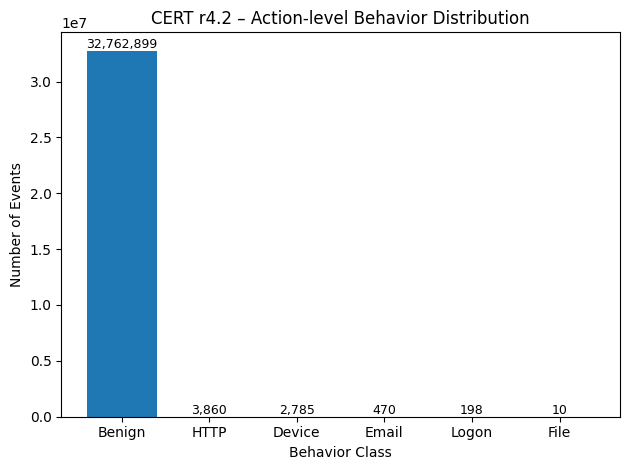

In [8]:
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
from collections import Counter

PARQUET_PATH = "/kaggle/input/cert-r4-2-multiclass/cert_r4.2_action_multiclass.parquet"
BATCH_SIZE = 1_000_000

dataset = ds.dataset(PARQUET_PATH, format="parquet")

LABEL_MAP = {
    0: "Benign",
    1: "Logon",
    2: "Device",
    3: "File",
    4: "Email",
    5: "HTTP"
}

label_counter = Counter()
total_rows = 0

# ✅ API ĐÚNG CHO PYARROW HIỆN TẠI
for batch in dataset.to_batches(columns=["label"], batch_size=BATCH_SIZE):
    labels = batch.column("label").to_pylist()
    total_rows += len(labels)
    label_counter.update(labels)

print("Label distribution (human-readable):")
for k in sorted(label_counter):
    print(f"{LABEL_MAP.get(k, 'Unknown')}: {label_counter[k]}")

# print("✅ Done streaming parquet")
# print("Total rows:", total_rows)
# print("Label distribution:", dict(sorted(label_counter.items())))

# ===== PLOT =====
items = [(l, label_counter[l]) for l in label_counter]
items.sort(key=lambda x: x[1], reverse=True)

labels_num = [i[0] for i in items]
counts = [i[1] for i in items]
labels_txt = [LABEL_MAP.get(l, "Unknown") for l in labels_num]


plt.figure()
bars = plt.bar(labels_txt, counts)
plt.xlabel("Behavior Class")
plt.ylabel("Number of Events")
plt.title("CERT r4.2 – Action-level Behavior Distribution")
# plt.yscale("log")
# plt.ylim(1, 1e8)

# plt.yticks(
#     [1, 1e5, 1e7],
#     [r"$10^0$", r"$10^4$", r"$10^8$"]
# )
plt.xticks(rotation=0)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,}",        # format có dấu phẩy
        ha='center',
        va='bottom',
        fontsize=9
    )
plt.tight_layout()
plt.show()


In [3]:
import pyarrow.dataset as ds

PARQUET_PATH = "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet"

dataset = ds.dataset(PARQUET_PATH, format="parquet")

print("Columns:")
for col in dataset.schema.names:
    print(col)


Columns:
user
ts
label
act_type
hour
dow
is_weekend
is_night
role_id
dept_id
team_id
psy_O
psy_C
psy_E
psy_A
psy_N
content_len
email_is_external
email_has_attachment
email_num_attachments
file_is_executable
file_is_sensitive
http_is_risky


In [5]:
import pyarrow.dataset as ds

dataset = ds.dataset(
    "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet",
    format="parquet"
)

batch = next(
    dataset.to_batches(
        columns=[
            # === CORE ===
            "user",
            "ts",
            "label",
            "act_type",

            # === TIME ===
            "hour",
            "dow",
            "is_weekend",
            "is_night",

            # === USER CONTEXT ===
            "role_id",
            "dept_id",
            "team_id",
            "psy_O",
            "psy_C",
            "psy_E",
            "psy_A",
            "psy_N",

            # === CONTENT ===
            "content_len",

            # === EMAIL ===
            "email_is_external",
            "email_has_attachment",
            "email_num_attachments",

            # === FILE ===
            "file_is_executable",
            "file_is_sensitive",

            # === HTTP ===
            "http_is_risky"
        ],
        batch_size=200
    )
)

batch.to_pandas()


,user,ts,label,act_type,hour,dow,is_weekend,is_night,role_id,dept_id,...,psy_E,psy_A,psy_N,content_len,email_is_external,email_has_attachment,email_num_attachments,file_is_executable,file_is_sensitive,http_is_risky
0,AAE0190,1262592540,0,1,8,0,0,0,23,5,...,14.0,50.0,29.0,0,0,0,0,0,0,0
1,AAE0190,1262592650,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,456,0,0,0,0,0,1
2,AAE0190,1262592730,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,333,0,0,0,0,0,0
3,AAE0190,1262592844,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,440,0,0,0,0,0,0
4,AAE0190,1262592960,0,5,8,0,0,0,23,5,...,14.0,50.0,29.0,385,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,AAE0190,1262685309,0,5,9,1,0,0,23,5,...,14.0,50.0,29.0,295,0,0,0,0,0,0
196,AAE0190,1262685410,0,4,9,1,0,0,23,5,...,14.0,50.0,29.0,306,0,1,1,0,0,0
197,AAE0190,1262685457,0,5,9,1,0,0,23,5,...,14.0,50.0,29.0,218,0,0,0,0,0,0
198,AAE0190,1262685644,0,5,10,1,0,0,23,5,...,14.0,50.0,29.0,438,0,0,0,0,0,0


In [8]:
import pandas as pd

df_batch = batch.to_pandas()

df_batch['datetime'] = pd.to_datetime(df_batch['ts'], unit='s')
df_batch[['ts','datetime','hour','is_night']]



,ts,datetime,hour,is_night
0,1262592540,2010-01-04 08:09:00,8,0
1,1262592650,2010-01-04 08:10:50,8,0
2,1262592730,2010-01-04 08:12:10,8,0
3,1262592844,2010-01-04 08:14:04,8,0
4,1262592960,2010-01-04 08:16:00,8,0
...,...,...,...,...
195,1262685309,2010-01-05 09:55:09,9,0
196,1262685410,2010-01-05 09:56:50,9,0
197,1262685457,2010-01-05 09:57:37,9,0
198,1262685644,2010-01-05 10:00:44,10,0


In [14]:
import pyarrow.dataset as ds
import pandas as pd

dataset = ds.dataset(
    "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet",
    format="parquet"
)

insider_users = set()

for batch in dataset.to_batches(columns=["user","label"], batch_size=1_000_000):
    df = batch.to_pandas()
    insiders = df.loc[df["label"] > 0, "user"].unique()
    insider_users.update(insiders)

len(insider_users)
malicious_count = []

for batch in dataset.to_batches(columns=["user","label"], batch_size=1_000_000):
    df = batch.to_pandas()
    tmp = df[df["label"] > 0].groupby("user").size()
    malicious_count.append(tmp)

malicious_count = pd.concat(malicious_count)
malicious_count = malicious_count.groupby(level=0).sum()

malicious_count.sort_values(ascending=False).head(10)

target_user = malicious_count.index[0]

for batch in dataset.to_batches(
    columns=["user","act_type","ts","hour","is_night","label"],
    batch_size=500_000
):
    df = batch.to_pandas()
    suspicious = df[(df["user"]==target_user) & (df["label"]>0)]
    if not suspicious.empty:
        print(suspicious.head())
        break


          user  act_type          ts  hour  is_night  label
59778  AAF0535         5  1277715068     8         0      2
59789  AAF0535         5  1277721181    10         0      2
59795  AAF0535         5  1277722850    11         0      2
59796  AAF0535         5  1277723776    11         0      2
59797  AAF0535         5  1277724205    11         0      2


Total actions of user AAF0535 : 6731


,datetime,act_name,hour,is_night,label
0,2010-01-04 08:56:00,logon,8,0,0
1,2010-01-04 09:06:37,http,9,0,0
2,2010-01-04 09:19:28,http,9,0,0
3,2010-01-04 09:24:04,http,9,0,0
4,2010-01-04 10:03:07,http,10,0,0
5,2010-01-04 10:11:49,http,10,0,0
6,2010-01-04 10:20:26,http,10,0,0
7,2010-01-04 10:36:36,http,10,0,0
8,2010-01-04 11:15:27,http,11,0,0
9,2010-01-04 11:20:14,http,11,0,0


Malicious actions: 221

Action distribution (malicious):


act_name
http      122
device     88
email      11
Name: count, dtype: int64


Hour distribution (malicious):


hour
8      2
9     24
10    29
11    21
12    35
13    31
14    37
15    22
16    19
17     1
Name: count, dtype: int64

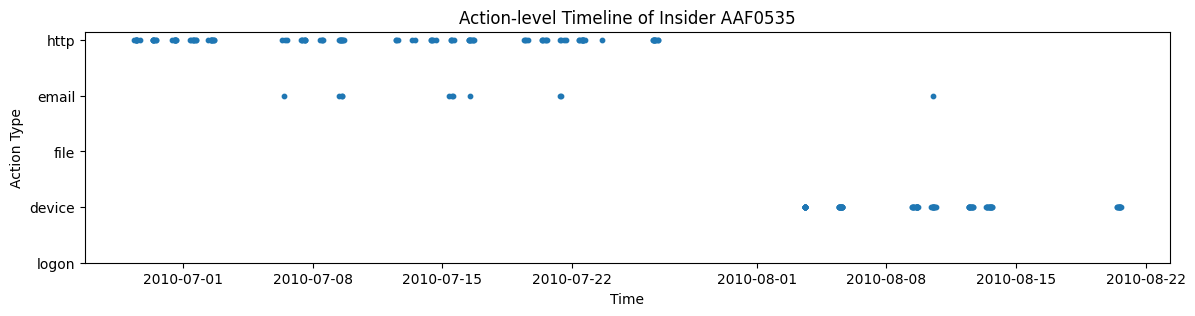

In [15]:
# ===== TRACE ACTION-LEVEL TIMELINE FOR USER AAF0535 (ONE CELL) =====

import pyarrow.dataset as ds
import pandas as pd
import json
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
PARQUET_PATH = "/kaggle/input/cert-r42-all/cert_r4.2_action_level.parquet"
ACT_MAP_PATH = "/kaggle/input/cert-r42-all/act_type_map.json"
TARGET_USER = "AAF0535"
BATCH_SIZE = 500_000

# ---------- LOAD ACTION MAP ----------
with open(ACT_MAP_PATH, "r") as f:
    act_map = json.load(f)

# ---------- LOAD DATASET ----------
dataset = ds.dataset(PARQUET_PATH, format="parquet")

records = []

for batch in dataset.to_batches(
    columns=[
        "user","ts","hour","dow","is_weekend","is_night",
        "act_type","label",
        "email_is_external","email_has_attachment",
        "file_is_executable","file_is_sensitive",
        "http_is_risky"
    ],
    batch_size=BATCH_SIZE
):
    df = batch.to_pandas()
    df = df[df["user"] == TARGET_USER]
    if not df.empty:
        records.append(df)

# ---------- CONCAT & SORT ----------
timeline = pd.concat(records).sort_values("ts").reset_index(drop=True)

# ---------- TIME CONVERSION ----------
timeline["datetime"] = pd.to_datetime(timeline["ts"], unit="s")

# ---------- MAP ACTION NAME ----------
timeline["act_name"] = timeline["act_type"].astype(str).map(act_map)

print("Total actions of user", TARGET_USER, ":", len(timeline))

# ---------- SHOW FIRST ROWS ----------
display(
    timeline[
        ["datetime","act_name","hour","is_night","label"]
    ].head(20)
)

# ---------- FILTER MALICIOUS ----------
mal_timeline = timeline[timeline["label"] > 0]

print("Malicious actions:", len(mal_timeline))

# ---------- STATISTICS ----------
print("\nAction distribution (malicious):")
display(mal_timeline["act_name"].value_counts())

print("\nHour distribution (malicious):")
display(mal_timeline["hour"].value_counts().sort_index())

# ---------- VISUALIZE TIMELINE ----------
plt.figure(figsize=(14,3))
plt.scatter(
    mal_timeline["datetime"],
    mal_timeline["act_type"],
    s=10
)
plt.yticks(
    ticks=[1,2,3,4,5],
    labels=["logon","device","file","email","http"]
)
plt.title(f"Action-level Timeline of Insider {TARGET_USER}")
plt.xlabel("Time")
plt.ylabel("Action Type")
plt.show()
